### Simulate RDD Data 

# Make some choices

Running this cell will define the variables of interest, our hyperparameters and some training options.

Make sure your Google Colab runtime has a GPU. You can turn this on via:

`Runtime -> Change Runtime type -> Hardware Accelerator -> GPU`

In [3]:
import wgan
import torch
import pandas as pd
from rdd import rdd 
import numpy as np
import importlib
importlib.reload(wgan)
#assert torch.cuda.is_available()

#Generate X
cont1 = ["x"] 
# Y | X 
cont2 = ["y"] 
text2 = ["x"] 

# 

lbound1 = {"x": -1}
ubound1 = {"x": 1} 
lbound2 = {"y": 0}
ubound2 = {"y": 1}

# T | X 

### Lee data

In [30]:
file = "data/cleaned/lee.csv"
df = pd.read_csv(file)

dfa = df[df['x']>0].copy()
print(dfa.head())

dfb = df[df['x']<=0].copy()
d= [64,64,64]
dc=[128,128,128]

data_wrapper1 = wgan.DataWrapper(df,cont1,continuous_lower_bounds=lbound1,
                                              continuous_upper_bounds=ubound1)
x1,context1 = data_wrapper1.preprocess(df)
specs1 = wgan.Specifications(data_wrapper1,
                             batch_size=256,
                             max_epochs=1000,
                             generator_lr = 0.0005, 
                              critic_lr = 0.0005, 
                              optimizer='Adam', 
                              critic_d_hidden=dc,
                              generator_d_hidden=d,
                               critic_gp_factor=5, 
                               print_every=100)
#generator1 = wgan.Generator(specs1)
#critic1 = wgan.Critic(specs1)


data_wrapper2 = wgan.DataWrapper(df,cont2,context_vars=text2,continuous_lower_bounds=lbound2,
                                              continuous_upper_bounds=ubound2,scale=False)
x2a,context2a = data_wrapper2.preprocess(dfa)
specs2a = wgan.Specifications(data_wrapper2,
                              batch_size=512,
                              max_epochs=1000,
                              generator_d_noise=1,
                              critic_d_hidden=[256,128,64],generator_d_hidden=d,critic_gp_factor=2, 
                                     print_every=100,generator_dropout=0.4)
#generator2a = wgan.Generator(specs2a)
#critic2a = wgan.Critic(specs2a)


data_wrapper2b = wgan.DataWrapper(dfb,cont2,continuous_lower_bounds=lbound2,
                                  continuous_upper_bounds=ubound2)
x2b,context2b = data_wrapper2.preprocess(dfb)
specifications2b = wgan.Specifications(data_wrapper2,batch_size=256,max_epochs=1000,generator_d_noise=1,
                                       critic_d_hidden=dc,generator_d_hidden=d,critic_gp_factor=0.5,
                                     print_every=100,generator_dropout=0.3)
#generator2b = wgan.Generator(specifications2b)
#critic2b = wgan.Critic(specifications2b)

          x         y
0  0.104869  0.580962
1  0.139252  0.461058
3  0.086822  0.584580
4  0.399358  0.580286
5  0.168077  0.624352
settings: {'critic_d_hidden': [128, 128, 128], 'critic_dropout': 0, 'critic_steps': 15, 'critic_lr': 0.0005, 'critic_gp_factor': 5, 'generator_d_hidden': [64, 64, 64], 'generator_dropout': 0.1, 'generator_lr': 0.0005, 'generator_d_noise': 1, 'gaussian_similarity_penalty': None, 'optimizer': 'Adam', 'max_epochs': 1000, 'batch_size': 256, 'test_set_size': 16, 'load_checkpoint': None, 'save_checkpoint': None, 'save_every': 100, 'print_every': 100, 'device': 'cpu'}
settings: {'critic_d_hidden': [256, 128, 64], 'critic_dropout': 0, 'critic_steps': 15, 'critic_lr': 0.0001, 'critic_gp_factor': 2, 'generator_d_hidden': [64, 64, 64], 'generator_dropout': 0.4, 'generator_lr': 0.0001, 'generator_d_noise': 1, 'gaussian_similarity_penalty': None, 'optimizer': 'AdamHD', 'max_epochs': 1000, 'batch_size': 512, 'test_set_size': 16, 'load_checkpoint': None, 'save_checkpoint

Run the next cell to train the models. You can abort at any time to continue with the evaluation.

In [31]:
# Option 1: train from scratch
wgan.train(generator1, critic1, x1, context1, specs1)
#wgan.train(generator2a, critic2a, x2a, context2a, specs2a)
#wgan.train(generator2b, critic2b, x2b, context2b, specifications2b)

epoch 0 | step 27 | WD_test 0.09 | WD_train 0.21 | sec passed 0 |
epoch 100 | step 2627 | WD_test 0.15 | WD_train 0.19 | sec passed 23 |
epoch 200 | step 5227 | WD_test 0.48 | WD_train 0.27 | sec passed 24 |
epoch 300 | step 7827 | WD_test 0.22 | WD_train 0.11 | sec passed 24 |
epoch 400 | step 10427 | WD_test 0.14 | WD_train 0.26 | sec passed 24 |
epoch 500 | step 13027 | WD_test 0.14 | WD_train -0.01 | sec passed 24 |
epoch 600 | step 15627 | WD_test -0.14 | WD_train 0.19 | sec passed 24 |
epoch 700 | step 18227 | WD_test -0.12 | WD_train 0.06 | sec passed 24 |
epoch 800 | step 20827 | WD_test 0.25 | WD_train 0.17 | sec passed 24 |
epoch 900 | step 23427 | WD_test 0.4 | WD_train 0.22 | sec passed 25 |


Alternatively, you can load our pre-trained parameters:

In [7]:
# Option 2: load trained model parameters
def load_saved_parameters(type):
  for model, name in zip([generator1, critic1,
                          generator2a, critic2a, 
                          generator2b, critic2b], 
                         ["G1","C1", "G2a","C2a", "G2b", "C2b"]):
      state_dict = torch.load("trained_models/" + name + "_{}.pth".format(type))
      model.load_state_dict(state_dict)

load_saved_parameters("lee")

To get a simulated data frame, we use the `DataWrapper.apply_generator(generator, df)` method, which updates columns in `df` with data simulated from `generator` wherever possible. We can therefore chain multiple calls together to build up a fake dataframe from multiple (partial) generators.
Similarly, we can add a column with the values of the critic using the `DataWrapper.apply_critic(critic, df)` method.

We'll wrap everything into a function so that we can repeat later.

In [32]:
def apply_models_to_data():
    s = df.sample(int(1e4),replace=True)
    s = data_wrapper1.apply_generator(generator1,s) 
    dfa = s[s['x']>0].copy()
    dfb = s[s['x']<=0].copy() 
    #first generate x 
    dfa = data_wrapper2.apply_generator(generator2a,dfa)
    dfb = data_wrapper2.apply_generator(generator2b,dfb)
    return pd.concat([dfa,dfb],axis=0,ignore_index=True)

Estimation Equation:	 y ~ TREATED + x
0.09168712326674382


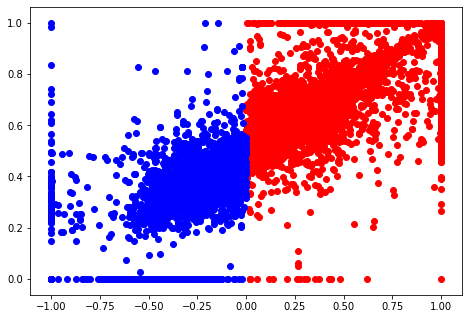

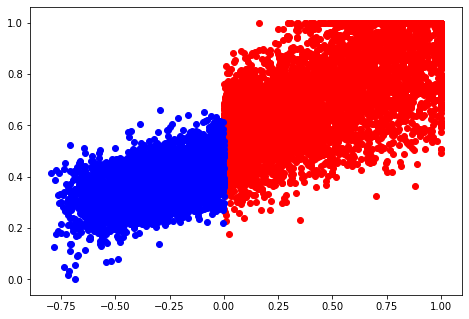

In [33]:
import matplotlib.pyplot as plt
df_fake = apply_models_to_data()
print(rdd_estimate(df_fake)) 

fig=plt.figure() 
ax=fig.add_axes([0,0,1,1])
ax.scatter(dfa['x'],dfa['y'], color='r')
ax.scatter(dfb['x'],dfb['y'], color='b')

fig2=plt.figure() 
ax=fig2.add_axes([0,0,1,1])
ax.scatter(df_fake.loc[df_fake['x']>0,'x'],df_fake.loc[df_fake['x']>0,'y'], color='r')
ax.scatter(df_fake.loc[df_fake['x']<=0,'x'],df_fake.loc[df_fake['x']<=0,'y'], color='b')

In [14]:
print(dfa['y'].mean())
print(dfb['y'].mean())

print(df_fake.loc[df_fake['x']>0,'y'].mean())
print(df_fake.loc[df_fake['x']<=0,'y'].mean())

0.6978809707176532
0.3465220178467153
0.5926358
0.3897724


In [15]:
def rdd_estimate(data):
    bandwidth_opt = rdd.optimal_bandwidth(data['y'], data['x'], cut=0) 
    data_rdd = rdd.truncated_data(data, 'x', bandwidth_opt, cut=0) 
    model = rdd.rdd(data_rdd, 'x', 'y', cut=0)
    return model.fit().params[1]

Finally, we can examine our generated data with the `compare_dfs` function.


In [25]:
def evaluate_results():
  # Let's print the att!
  print("--------------------RDD--------------------")
  print("real:",rdd_estimate(df)) 
  print("fake:",rdd_estimate(df_fake))

  # Now, we'll compare our fake data to the real data
  table_groupby = ["t"]
  scatterplot = dict(x= ["x"],
                     y= ["y"],
                     samples = 5000, smooth = 0)
  histogram = dict(variables=['x','y','x','y'],
                   nrow=2, ncol=2)
  wgan.compare_dfs(df, df_fake, figsize=5, histogram=histogram, scatterplot=scatterplot)


--------------------RDD--------------------
Estimation Equation:	 y ~ TREATED + x
real: 0.08522574425161496
Estimation Equation:	 y ~ TREATED + x
fake: 0.09168712326674382
-------------comparison of means-------------
source  fake  real
x       0.12  0.13
y       0.56  0.55
-------------comparison of stds-------------
source  fake  real
x       0.45  0.46
y       0.22  0.24


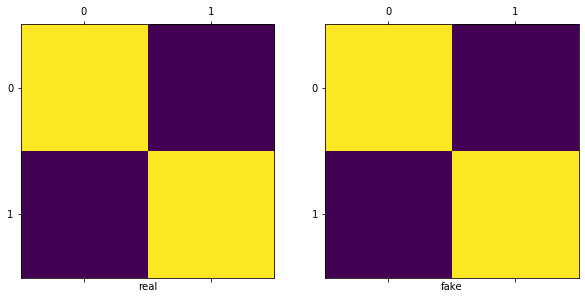

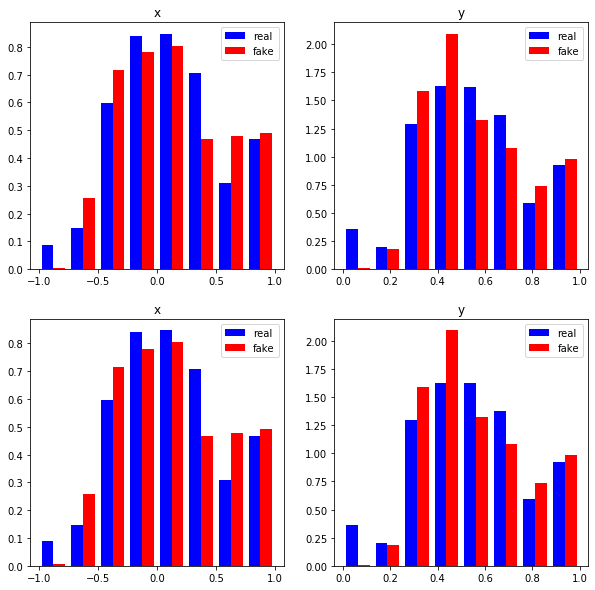

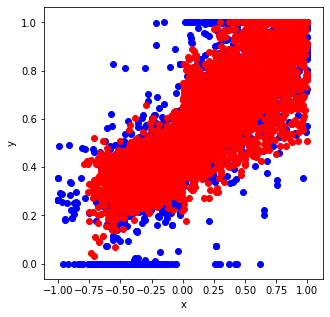

In [34]:
evaluate_results()

Looks good enough? Then save the models, generate a large dataframe and export it.

In [35]:
# save trained model parameters
def save_trained_parameters(type):
  #%mkdir trained_models
  for model, name in zip([generator1,critic1,generator2a,critic2a,generator2b,critic2b], ["G1","C1","G2a","C2a","G2b","C2b"]):
      torch.save(model.state_dict(), "trained_models/" + name + "_{}.pth".format(type))

In [36]:
save_trained_parameters("lee")

In [37]:
# generate and save data of a certain sample size
def save_generated_data(type,n_samples):
    s = df.sample(int(n_samples),replace=True)
    s = data_wrapper1.apply_generator(generator1,s) 
    #print(s.head())
    dfa = s[s['x']>0]
    dfb = s[s['x']<0]
    #print(dfb.shape)
    #first generate x 
    dfa = data_wrapper2.apply_generator(generator2a,dfa)
    dfb = data_wrapper2.apply_generator(generator2b,dfb)
    df_fake = pd.concat([dfa,dfb],axis=0,ignore_index=True)
    df_fake.to_feather("data/generated/{}_generated.feather".format(type))

In [38]:
save_generated_data("lee",int(1e7))